# Setup

In [2]:
# imports 
import pandas as pd
import opendatasets as od
import time
import datetime
import torch.nn as nn
from torchsummary import summary
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib.pyplot import xticks
import tqdm
from tqdm.notebook import tqdm_notebook
tqdm.tqdm.pandas()
tqdm_notebook.pandas()

In [9]:
dataset_url = 'https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction'
od.download(dataset_url)

In [3]:
df = pd.read_csv('./NYCTaxiFares_medium.csv')
df['pickup_datetime'].max()

'2015-06-30 23:59:45 UTC'

In [4]:
df.drop(labels=['Unnamed: 0', 'key'], axis=1, inplace=True)

# Pre-processing

In [10]:
#boundary limit
boundary={
    'north_lat':41.709555,
    'south_lat':40.573143,
    'east_long':-72.986532,
    'west_long':-74.263242
}

df.loc[~((df.pickup_longitude >= boundary['west_long'] ) & (df.pickup_longitude <= boundary['east_long']) &
            (df.pickup_latitude >= boundary['south_lat']) & (df.pickup_latitude <= boundary['north_lat']) &
            (df.dropoff_longitude >= boundary['west_long']) & (df.dropoff_longitude <= boundary['east_long']) &
            (df.dropoff_latitude >=boundary['south_lat']) & (df.dropoff_latitude <= boundary['north_lat'])),'is_outlier_loc']=1
df.loc[((df.pickup_longitude >= boundary['west_long'] ) & (df.pickup_longitude <= boundary['east_long']) &
            (df.pickup_latitude >= boundary['south_lat']) & (df.pickup_latitude <= boundary['north_lat']) &
            (df.dropoff_longitude >= boundary['west_long']) & (df.dropoff_longitude <= boundary['east_long']) &
            (df.dropoff_latitude >=boundary['south_lat']) & (df.dropoff_latitude <= boundary['north_lat'])),'is_outlier_loc']=0

df=df.loc[df['is_outlier_loc']==0]
df.drop(['is_outlier_loc'],axis=1,inplace=True)

/var/folders/66/_06nwy091cs2zs1kz4v_7_w40000gn/T/ipykernel_51617/2060664732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['is_outlier_loc'],axis=1,inplace=True)


In [11]:
df = df.loc[df['fare_amount'] > 2.5]

In [12]:
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...
6927977,22.9,2012-08-24 07:38:00 UTC,-73.911487,40.850998,-73.910733,40.850180,2
6927978,3.5,2012-09-11 06:50:56 UTC,-73.978780,40.737156,-73.985742,40.740130,1
6927979,9.0,2014-01-26 05:53:38 UTC,-73.988435,40.748540,-73.986100,40.772325,1
6927980,9.7,2010-04-07 11:52:00 UTC,-73.994625,40.750453,-73.972018,40.757498,5


In [13]:

def havardsine_distance(lat1, long1, lat2, long2):
    r = 6371

    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)

    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(long2 - long1)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = (r * c) # convert to kilometer
    return d


In [14]:
df = df.sort_values(by='pickup_datetime', ascending=True)

df.head(6)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
880228,15.0,2009-01-01 00:00:46 UTC,-73.953738,40.806762,-73.989427,40.769542,1
661006,5.8,2009-01-01 00:01:04 UTC,-73.995133,40.734111,-73.998232,40.722874,2
3094958,10.6,2009-01-01 00:03:04 UTC,-74.007669,40.742966,-73.980098,40.748366,4
6567422,10.1,2009-01-01 00:04:59 UTC,-73.948849,40.778003,-73.977678,40.748692,2
4909370,3.8,2009-01-01 00:05:16 UTC,-73.977193,40.763745,-73.975991,40.764790,1
2247283,7.4,2009-01-01 00:09:00 UTC,-73.999446,40.743925,-73.992176,40.750398,2


In [16]:
calculated_distance = []
converted_datetime = []
airport = []

def main_data_process(values):
    plat = values['pickup_latitude']
    plon = values['pickup_longitude']
    dlat = values['dropoff_latitude']
    dlon = values['dropoff_longitude']
    distance = havardsine_distance(plat, plon, dlat, dlon)
    calculated_distance.append(distance)

    date_object = pd.Timestamp(values['pickup_datetime'])
    converted_datetime.append(date_object)

    airport_related = close_to_airport(values)
    airport.append(airport_related)

df.progress_apply(main_data_process, axis=1)
df['dist_km'] = calculated_distance
df['pickup_datetime'] = converted_datetime
df['is_by_airport'] = airport

  0%|          | 0/6754464 [00:00<?, ?it/s]

In [ ]:
df


In [15]:
# When I wrote this code, only God and I knew what was going on. Today, only God knows.
def close_to_airport(values):
    pickup_latitude = values['pickup_latitude']
    pickup_longitude = values['pickup_longitude']
    dropoff_latitude = values['dropoff_latitude']
    dropoff_longitude = values['dropoff_longitude']

    # JFK is special, it needs a bigger radius
    jfkpickup = havardsine_distance(pickup_latitude, pickup_longitude, 40.6489467, -73.7949986) <= 1.50
    jfkdropoff = havardsine_distance(dropoff_latitude, dropoff_longitude, 40.6489467,-73.7949986) <= 1.50

    # Newark is a small airport but their parking log is BIG.
    newarkpickup = havardsine_distance(pickup_latitude, pickup_longitude, 40.691547, -74.180202) <= 1.00
    newarkdropoff = havardsine_distance(dropoff_latitude, dropoff_longitude, 40.691547, -74.180202) <= 1.00

    # Third largest, it's an abstract airport with a stretched out U shaped parking place
    # LaGuardia
    laguardiapickup = havardsine_distance(pickup_latitude, pickup_longitude, 40.773855, -73.871712) <= 0.50
    laguardiadropoff = havardsine_distance(dropoff_latitude, dropoff_longitude, 40.773855, -73.871712) <= 0.50

    return 1 if jfkpickup or jfkdropoff or newarkpickup or newarkdropoff or laguardiapickup or laguardiadropoff else 0

In [ ]:
df

In [17]:
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,is_by_airport,EDTdate
880228,15.0,2009-01-01 00:00:46+00:00,-73.953738,40.806762,-73.989427,40.769542,1,5.114331,0,2008-12-31 20:00:46+00:00
661006,5.8,2009-01-01 00:01:04+00:00,-73.995133,40.734111,-73.998232,40.722874,2,1.276494,0,2008-12-31 20:01:04+00:00
3094958,10.6,2009-01-01 00:03:04+00:00,-74.007669,40.742966,-73.980098,40.748366,4,2.399019,0,2008-12-31 20:03:04+00:00
6567422,10.1,2009-01-01 00:04:59+00:00,-73.948849,40.778003,-73.977678,40.748692,2,4.064204,0,2008-12-31 20:04:59+00:00
4909370,3.8,2009-01-01 00:05:16+00:00,-73.977193,40.763745,-73.975991,40.764790,1,0.154110,0,2008-12-31 20:05:16+00:00
...,...,...,...,...,...,...,...,...,...,...
3211962,6.5,2015-06-30 23:55:51+00:00,-74.010147,40.720520,-74.000557,40.727139,1,1.093045,0,2015-06-30 19:55:51+00:00
3088533,20.0,2015-06-30 23:56:00+00:00,-73.970154,40.757011,-73.962608,40.708641,1,5.415985,0,2015-06-30 19:56:00+00:00
2031461,14.5,2015-06-30 23:56:50+00:00,-73.992104,40.734531,-73.960335,40.775703,1,5.302802,0,2015-06-30 19:56:50+00:00
2203030,11.0,2015-06-30 23:59:03+00:00,-73.969475,40.750282,-73.993965,40.751568,1,2.067921,0,2015-06-30 19:59:03+00:00


In [18]:
df['Weekday'] = pd.to_numeric(df['EDTdate'].dt.strftime("%w")) # an int between 0 - 6, representing the weekdays
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,0,1)
df['Month'] = pd.to_numeric(df['EDTdate'].dt.strftime("%m")) # an int between 0 - 6, representing the weekdays

#Formatting this correctly, we can use the dates to get the historical weather data for the dates
df['FullDate'] = df['EDTdate'].dt.strftime('%x')

In [20]:
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,is_by_airport,EDTdate,Weekday,Hour,AMorPM,Month,FullDate
880228,15.0,2009-01-01 00:00:46+00:00,-73.953738,40.806762,-73.989427,40.769542,1,5.114331,0,2008-12-31 20:00:46+00:00,3,20,1,12,12/31/08
661006,5.8,2009-01-01 00:01:04+00:00,-73.995133,40.734111,-73.998232,40.722874,2,1.276494,0,2008-12-31 20:01:04+00:00,3,20,1,12,12/31/08
3094958,10.6,2009-01-01 00:03:04+00:00,-74.007669,40.742966,-73.980098,40.748366,4,2.399019,0,2008-12-31 20:03:04+00:00,3,20,1,12,12/31/08
6567422,10.1,2009-01-01 00:04:59+00:00,-73.948849,40.778003,-73.977678,40.748692,2,4.064204,0,2008-12-31 20:04:59+00:00,3,20,1,12,12/31/08
4909370,3.8,2009-01-01 00:05:16+00:00,-73.977193,40.763745,-73.975991,40.764790,1,0.154110,0,2008-12-31 20:05:16+00:00,3,20,1,12,12/31/08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211962,6.5,2015-06-30 23:55:51+00:00,-74.010147,40.720520,-74.000557,40.727139,1,1.093045,0,2015-06-30 19:55:51+00:00,2,19,1,6,06/30/15
3088533,20.0,2015-06-30 23:56:00+00:00,-73.970154,40.757011,-73.962608,40.708641,1,5.415985,0,2015-06-30 19:56:00+00:00,2,19,1,6,06/30/15
2031461,14.5,2015-06-30 23:56:50+00:00,-73.992104,40.734531,-73.960335,40.775703,1,5.302802,0,2015-06-30 19:56:50+00:00,2,19,1,6,06/30/15
2203030,11.0,2015-06-30 23:59:03+00:00,-73.969475,40.750282,-73.993965,40.751568,1,2.067921,0,2015-06-30 19:59:03+00:00,2,19,1,6,06/30/15


In [74]:
# lets have some weather-y fuuuuuuuuuuuun-fuuuuuun-function
# see this for doc https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf
weather_data = pd.read_csv('nyc-weather-data.csv')
weather_labels = ['SNWD', 'SNOW', 'AWND'] #snow depth, snowfall, wind speed
for index, item in enumerate(weather_labels):
    weather_data.loc[weather_data[item] <= -9999, item] = 0 # -9999 means that there is no data

weather_data['DATE'] = weather_data.apply(lambda row: datetime.datetime.strptime(str(row.DATE), '%Y%m%d').strftime('%m/%d/%y'), axis=1)
weather_data = weather_data[['DATE','PRCP','SNWD','SNOW','TMAX','TMIN','AWND']]

weather_data['TMIN'] = (weather_data['TMIN'] / 10) # the API returns degrees in an old format. We therefore convert the value to a tenth of its own form. Check the docu for this.
weather_data['TMAX'] = (weather_data['TMAX'] / 10) # min temperature and max temperateure
weather_data['PRCP'] = weather_data['PRCP'] / 10   # precipitation

weather_data['AWND'] = weather_data['AWND'] / 2.237 # meters per second
weather_data['SNOW'] = weather_data['SNOW'] / 10 # mm to cm
weather_data['SNWD'] = weather_data['SNWD'] / 10 # mm to cm

df.rename(columns={'FullDate':'DATE'}, inplace=True)

merged_df = pd.merge(df, weather_data, how="left", on="DATE")

In [22]:
df['DATE']

880228     12/31/08
661006     12/31/08
3094958    12/31/08
6567422    12/31/08
4909370    12/31/08
             ...   
3211962    06/30/15
3088533    06/30/15
2031461    06/30/15
2203030    06/30/15
5015769    06/30/15
Name: DATE, Length: 6779363, dtype: object

In [23]:
weather_data['DATE']

0       01/01/09
1       01/02/09
2       01/03/09
3       01/04/09
4       01/05/09
          ...   
2511    11/17/15
2512    11/18/15
2513    11/19/15
2514    11/20/15
2515    11/21/15
Name: DATE, Length: 2516, dtype: object

In [19]:
merged_df.dropna(how="any", inplace=True)

# EDA

In [20]:
merged_df.sort_values(by='fare_amount')

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,is_by_airport,EDTdate,Weekday,Hour,AMorPM,Month,FullDate
4754488,2.51,2009-05-16 16:11:10+00:00,-74.001419,40.746402,-73.996011,40.742252,1,0.648468,0,2009-05-16 12:11:10+00:00,6,12,1,5,05/16/09
1351948,2.51,2013-07-19 20:54:55+00:00,-73.991037,40.750782,-73.965743,40.772502,1,3.220444,0,2013-07-19 16:54:55+00:00,5,16,1,7,07/19/13
1086639,2.51,2014-06-22 13:57:33+00:00,-73.973264,40.678359,-74.008921,40.708090,1,4.468394,0,2014-06-22 09:57:33+00:00,0,9,0,6,06/22/14
5320630,2.51,2014-02-28 21:15:40+00:00,-73.985713,40.723013,-73.951460,40.785429,1,7.516165,0,2014-02-28 17:15:40+00:00,5,17,1,2,02/28/14
4770135,2.51,2012-07-03 18:11:54+00:00,-73.991920,40.737544,-73.996018,40.760631,1,2.590264,0,2012-07-03 14:11:54+00:00,2,14,1,7,07/03/12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215047,488.00,2011-09-08 00:32:00+00:00,-73.999437,40.721837,-74.048855,40.731560,1,4.302358,0,2011-09-07 20:32:00+00:00,3,20,1,9,09/07/11
101885,500.00,2011-09-12 09:33:56+00:00,-73.965961,40.640595,-73.965961,40.640595,1,0.000000,0,2011-09-12 05:33:56+00:00,1,5,0,9,09/12/11
3316931,500.00,2012-12-14 04:08:28+00:00,-73.849123,40.836440,-73.848573,40.836094,1,0.060176,0,2012-12-14 00:08:28+00:00,5,0,0,12,12/14/12
3206977,542.83,2015-02-03 14:50:22+00:00,-73.863289,40.769989,-73.959152,40.762569,1,8.115345,0,2015-02-03 10:50:22+00:00,2,10,0,2,02/03/15


In [98]:
print(merged_df['DATE'].min(),
merged_df['DATE'].max())

01/01/09 12/31/14


Text(0.5, 0, 'Distance (km)')

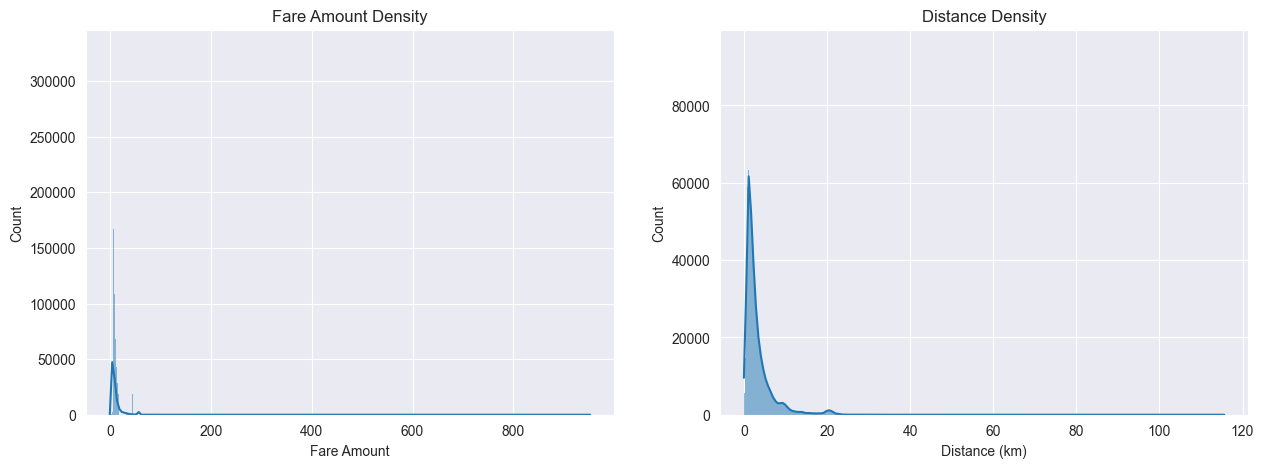

In [27]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

sns.histplot(merged_df['fare_amount'], ax=axs[0], kde=True)
axs[0].set_title("Fare Amount Density")
axs[0].set_xlabel("Fare Amount")

sns.histplot(merged_df['dist_km'], ax=axs[1], kde=True)
axs[1].set_title("Distance Density")
axs[1].set_xlabel("Distance (km)")

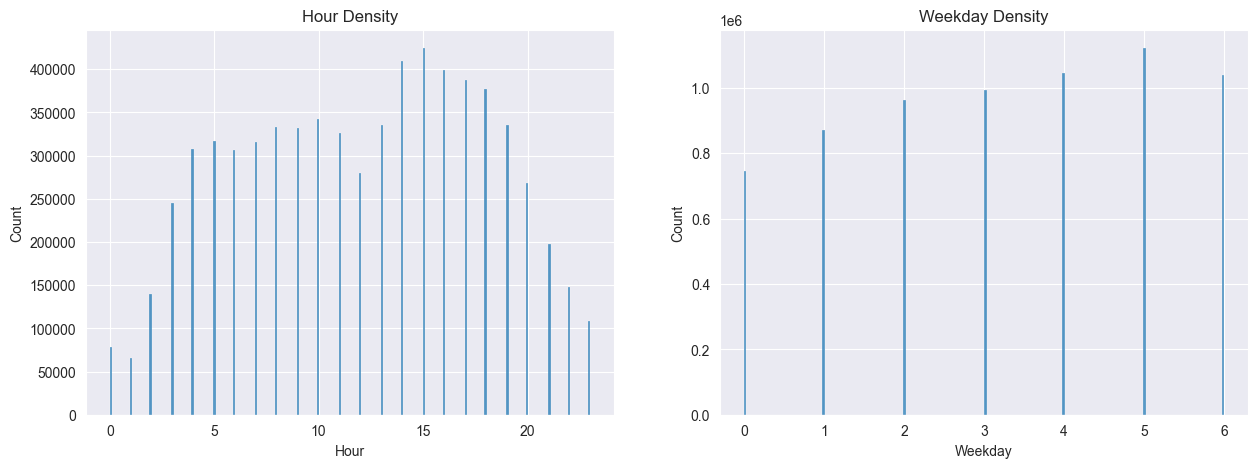

In [28]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

sns.histplot(merged_df, x='Hour', ax=axs[0])
axs[0].set_title('Hour Density')
axs[0].set_xlabel('Hour')

sns.histplot(merged_df, x='Weekday', ax=axs[1])
axs[1].set_title('Weekday Density')
axs[1].set_xlabel('Weekday')

plt.show()

In [29]:
"""
PRCP - Precipitation
SNOW - Snowfall - All 0?
SNWD - Snow depth - All 0?
TMAX - Max temperature
TMIN - Min temperature
AWND - Average wind speed
"""
# fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20,20))

# sns.histplot(merged_df['SNOW'], ax=axs[0][0])
# axs[0][0].set_title("SNOW distribution")
# axs[0][0].set_xlabel("SNOW")

# sns.histplot(merged_df['SNWD'], ax=axs[0][1])
# axs[0][1].set_title("SNWD distribution")
# axs[0][1].set_xlabel("SNWD")

# sns.histplot(merged_df['PRCP'], ax=axs[1][0])
# axs[1][0].set_title("PRCP")
# axs[1][0].set_xlabel("PRCP")

# sns.histplot(merged_df["AWND"], ax=axs[1][1])
# axs[1][1].set_title("AWND")
# axs[1][1].set_xlabel("AWND")

# sns.histplot(merged_df["TMAX"], ax=axs[2][0])
# axs[2][0].set_title("TMAX")
# axs[2][0].set_xlabel("TMAX")

# sns.histplot(merged_df["TMIN"], ax=axs[2][1])
# axs[2][1].set_title("TMIN")
# axs[2][1].set_xlabel("TMIN")


'\nPRCP - Precipitation\nSNOW - Snowfall - All 0?\nSNWD - Snow depth - All 0?\nTMAX - Max temperature\nTMIN - Min temperature\nAWND - Average wind speed\n'

# Processing

In [25]:
network_data = merged_df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'dist_km', 'passenger_count', 'Hour', 'AMorPM', 'Weekday', 'Month', 'fare_amount', 'is_by_airport','PRCP', 'SNWD', 'SNOW', 'TMAX', 'TMIN', 'AWND']]

prediction = network_data['fare_amount']

X = network_data.drop('fare_amount', axis=1)

y=prediction
print(max(y))
print(y.values)

952.0
[15.   5.8 10.6 ... 14.5 11.  50.5]
(6754464, 11)


In [26]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1)

In [27]:
scaler = StandardScaler()
#
train_X = scaler.fit_transform(train_X)
test_X = scaler.fit_transform(test_X)


In [47]:
test_y.values

array([ 8.5,  5.5,  8.9, ..., 13.7,  5.3,  4.5])

In [28]:
X = torch.tensor(train_X, dtype=torch.float)
y = torch.tensor(train_y.values.reshape(-1), dtype=torch.float)
test_X_tensor = torch.Tensor(test_X)
test_y_tensor = torch.Tensor(test_y.values.reshape(-1))

train_ds = torch.utils.data.TensorDataset(X, y)
test_ds = torch.utils.data.TensorDataset(test_X_tensor, test_y_tensor)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=128, shuffle=False)

In [31]:
# 0.938 loss in 150 epochs, huber loss, adam with 0.008 lr and 0.4 momentum in batchnorm1d, minmax scaler

dropout = 0.0
momentum = 0.7
class NYCTaxiPredictor(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(17, 64),
            nn.BatchNorm1d(64, momentum=momentum),
            nn.Dropout(dropout),
            nn.ReLU(),

            nn.Linear(64, 256),
            nn.BatchNorm1d(256, momentum=momentum),
            nn.Dropout(dropout),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128, momentum=momentum),
            nn.Dropout(dropout),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64, momentum=momentum),
            nn.Dropout(dropout),
            nn.ReLU(),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

model = NYCTaxiPredictor()
summary(model, tuple([17]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             384
       BatchNorm1d-2                   [-1, 32]              64
           Dropout-3                   [-1, 32]               0
              ReLU-4                   [-1, 32]               0
            Linear-5                   [-1, 64]           2,112
       BatchNorm1d-6                   [-1, 64]             128
           Dropout-7                   [-1, 64]               0
              ReLU-8                   [-1, 64]               0
            Linear-9                  [-1, 128]           8,320
      BatchNorm1d-10                  [-1, 128]             256
          Dropout-11                  [-1, 128]               0
             ReLU-12                  [-1, 128]               0
           Linear-13                   [-1, 64]           8,256
      BatchNorm1d-14                   

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
# optimizer = torch.optim.Adagrad(model.parameters(), lr=0.008)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.008, momentum=0.6)
# optimizer = torch.optim.ASGD(model.parameters(), lr=0.001)
# optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01, history_size=10, max_iter=4)
losses = []
# criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
# criterion = nn.MSELoss()
criterion = nn.HuberLoss()
# criterion = nn.SmoothL1Loss()

epochs = 150
flag=0
for epoch in range(epochs):
    train_loss=[]
    for i,data in enumerate(train_dl):
        X, y = data
        optimizer.zero_grad()
        output = model(X)
        # if i > 150 and flag == 0:
        #     optimizer = torch.optim.Adam(model.parameters(), lr=0.04, weight_decay=0.01)
        #     flag = 1
        # print(output.shape)
        # print(y.unsqueeze(-1))
        # y = y.unsqueeze(1)
        loss = criterion(output, y.unsqueeze(-1))
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    print("{}/{}".format(epoch + 1, epochs), np.mean(train_loss))
    losses.append(np.mean(train_loss))

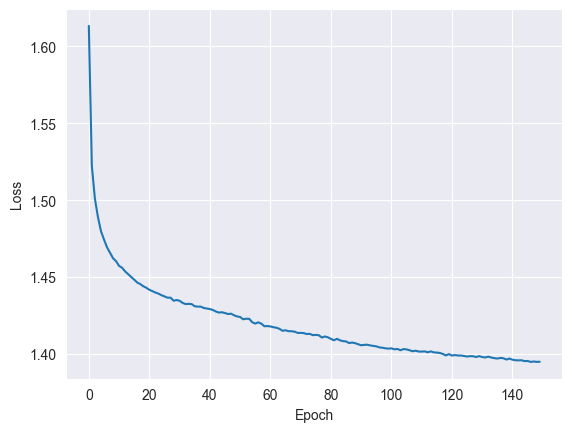

In [83]:
plt.plot(range(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [84]:
err = nn.MSELoss()
mse_err = []
with torch.no_grad():
  for data in test_dl:
    X, y = data
    output = model(X)
    for idx, val in enumerate(output):
        # print("pred:", val.item(), "truth:", y.unsqueeze(-1)[idx].item())
        loss = err(val, y.unsqueeze(-1)[idx])
        mse_err.append(loss.item())
#
err = nn.L1Loss()
l1_err = []
with torch.no_grad():
  for data in test_dl:
    X, y = data
    output = model(X)
    for idx, val in enumerate(output):
        # print("pred:", val.item(), "truth:", y.unsqueeze(-1)[idx].item())
        loss = err(val, y.unsqueeze(-1)[idx])
        l1_err.append(loss.item())
#
#
err = nn.SmoothL1Loss()
smooth_l1_err = []
with torch.no_grad():
  for data in test_dl:
    X, y = data
    output = model(X)
    for idx, val in enumerate(output):
        # print("pred:", val.item(), "truth:", y.unsqueeze(-1)[idx].item())
        loss = err(val, y.unsqueeze(-1)[idx])
        smooth_l1_err.append(loss.item())

1.834233159371777


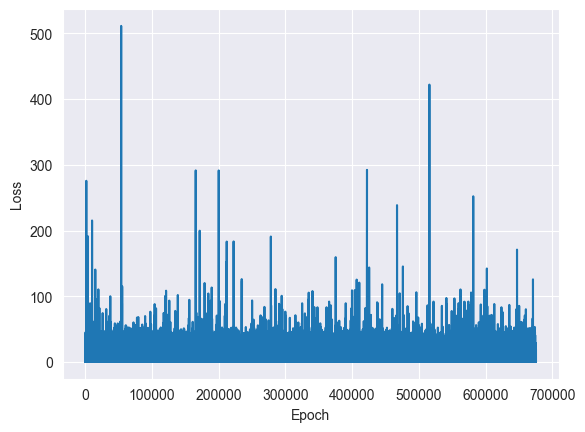

In [85]:
print(np.mean(l1_err))
plt.plot(range(len(l1_err)), l1_err)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

1.416355675203981


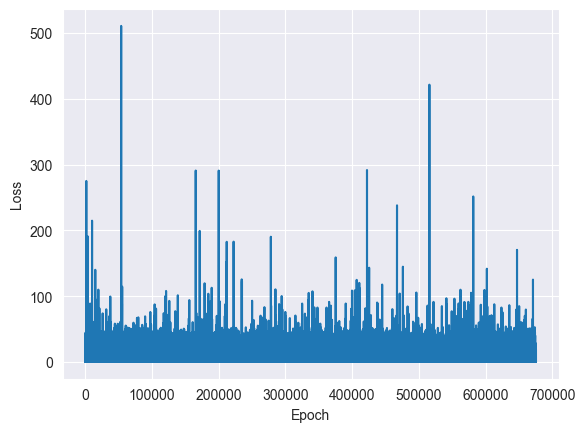

In [86]:
print(np.mean(smooth_l1_err))
plt.plot(range(len(smooth_l1_err)), smooth_l1_err)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

16.527078549382125


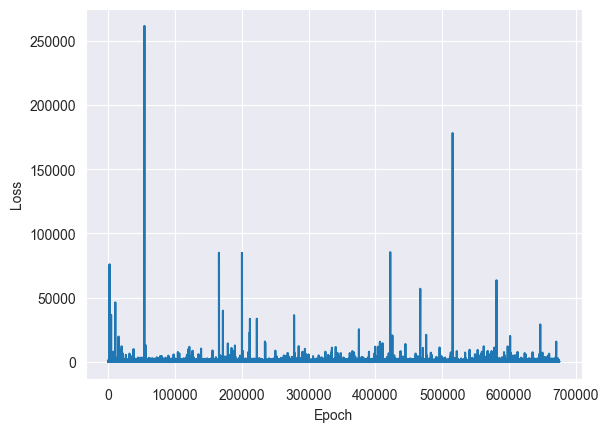

In [87]:
print(np.mean(mse_err))
plt.plot(range(len(mse_err)), mse_err)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()